In [ ]:
## model.py

In [3]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()


In [4]:
print('hi')

hi


In [5]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.2.1+cpu


C:\Users\SiFuBrO\AppData\Local\Temp\ipykernel_17056\2880966951.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [6]:
#!pip install --upgrade --force-reinstall pillow

In [7]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [8]:
model, preprocess = clip.load("ViT-B/32")
# model.cuda().eval()
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000022913FFD0D0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## 1. Get images and Text

In [11]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [12]:
import skimage

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

In [13]:
import os
from PIL import Image

orig_images = []
images = []
texts = []

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
    
    orig_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])
    
len(images)

C:\Users\SiFuBrO\anaconda3\envs\pytorch_cuda11.0_env\lib\site-packages\torchvision\transforms\functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


8

In [14]:
images[0].shape

torch.Size([3, 224, 224])

a portrait of an astronaut with the American flag


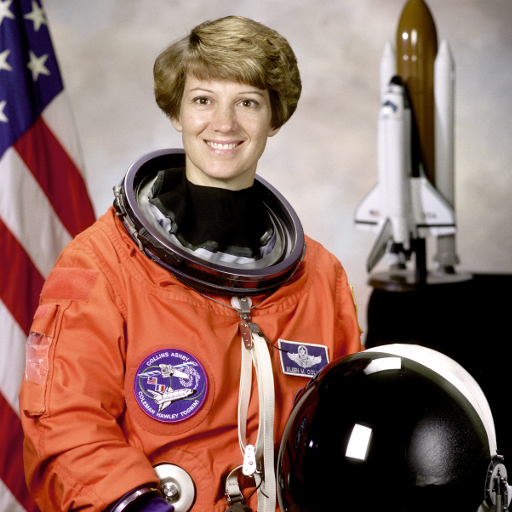

In [15]:
index = 0
print(texts[index])
orig_images[index]

a person looking at a camera on a tripod


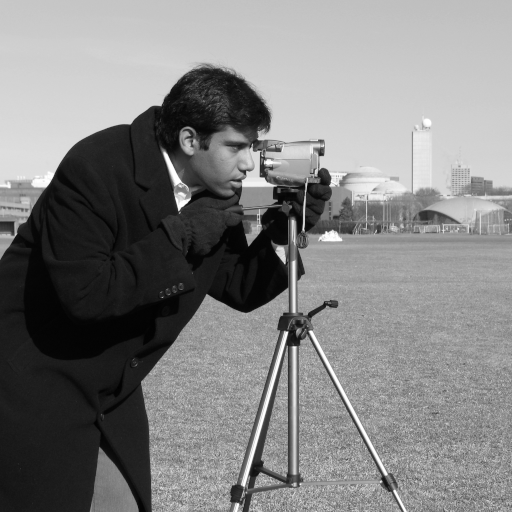

In [16]:
index = 1
print(texts[index])
orig_images[index]

In [17]:
texts

['a portrait of an astronaut with the American flag',
 'a person looking at a camera on a tripod',
 'a facial photo of a tabby cat',
 'a cup of coffee on a saucer',
 'a black-and-white silhouette of a horse',
 'a red motorcycle standing in a garage',
 'a page of text about segmentation',
 'a rocket standing on a launchpad']

In [18]:
images[0].shape

torch.Size([3, 224, 224])

## 2. Tokenize images and form a batch for images and texts

In [19]:
# images are already preprocessed: resize 224 -> center crop 224 -> RGB -> ToTensor() -> (m,sigma) normalization

# batch_size = 8
# stack images to form a batch -> [8, 3, 224, 224]
image_input = torch.tensor(np.stack(images)) #.cuda()  

# batch of [8, 77]
# context_length = 77
text_tokens = clip.tokenize(["This is " + txt for txt in texts])   #.cuda()

text_tokens

tensor([[49406,   589,   533,   320,  5352,   539,   550, 18376,   593,   518,
          2151,  4859, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   589,   533,   320,  2533,  1312,   536,   320,  3934,   525,
           320, 36141, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

## 3. Get the image and text features from the vision and text Transformer

In [20]:
with torch.no_grad():
    # (8, 512)
    image_features = model.encode_image(image_input).float()

    # gets the feature vector above the EOS token to use it as embedding for that caption
    # (8, 512)
    text_features = model.encode_text(text_tokens).float()

image_features.shape, text_features.shape

(torch.Size([8, 512]), torch.Size([8, 512]))

## 4. Normalize vectors & Compute Similarities

In [21]:
# convert to unit vectors
image_features /=   image_features.norm(dim=-1, keepdim = True)
text_features  /=  text_features.norm(dim=-1, keepdim = True)

In [23]:
text_features.shape

torch.Size([8, 512])

In [31]:
image_features_transposed = torch.transpose(image_features, 0, 1)
image_features_transposed.shape

torch.Size([512, 8])

In [33]:
# (8, 512) @ (512, 8) = (8, 8)
similarity = text_features @ image_features_transposed
similarity

tensor([[0.2767, 0.1657, 0.1682, 0.1495, 0.1636, 0.1501, 0.1300, 0.2206],
        [0.1859, 0.3048, 0.2083, 0.1367, 0.1955, 0.1608, 0.1886, 0.2069],
        [0.1196, 0.1595, 0.3074, 0.1660, 0.1533, 0.1249, 0.1209, 0.1187],
        [0.1482, 0.1742, 0.1839, 0.2931, 0.1521, 0.1217, 0.1438, 0.1228],
        [0.1147, 0.2131, 0.1458, 0.1543, 0.3448, 0.1674, 0.1725, 0.1487],
        [0.1548, 0.1198, 0.1542, 0.1253, 0.1631, 0.3207, 0.1427, 0.1594],
        [0.1468, 0.2015, 0.2011, 0.1984, 0.2011, 0.1633, 0.3539, 0.1596],
        [0.1919, 0.2017, 0.1777, 0.1384, 0.1707, 0.1583, 0.1742, 0.3028]])

In [40]:
# Similarities do not sum to 1. They are not normalized
similarity.sum(axis=-1)

tensor([1.4245, 1.5875, 1.2702, 1.3397, 1.4613, 1.3399, 1.6258, 1.5157])

In [37]:
#!pip install matplotlib

Text(0.5, 1.0, 'Cosine similarity between text and image features')

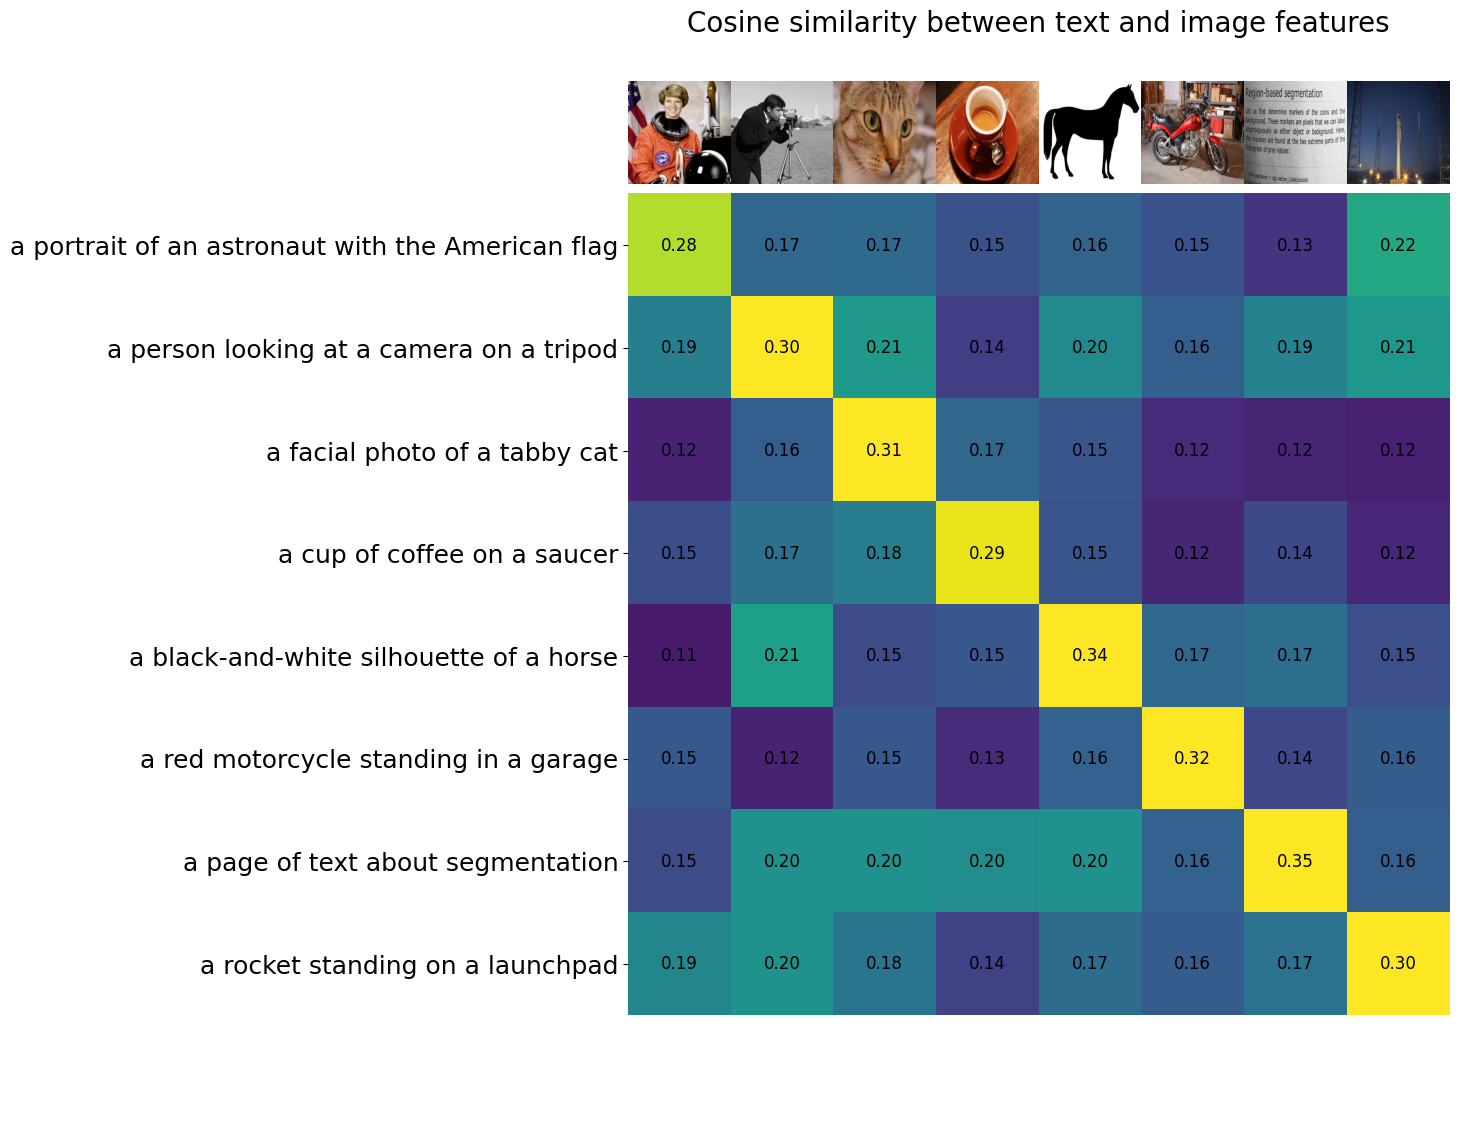

In [39]:
import matplotlib.pyplot as plt

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(orig_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## 5. Zero-shot classification

In [ ]:
# Form a caption for each class:
# This is a photo of...

In [42]:
image_features.shape

torch.Size([8, 512])

In [85]:
new_items = ["woman","astronaut","spaceship","airplane","camera","man","dog","cat","horse","elephant","spoon","table","color","coffee","car","bike","text"]

text_descriptions = [f"This is a {txt}" for txt in new_items]
len(text_descriptions)

17

In [60]:
text_tokens = clip.tokenize(text_descriptions)
text_tokens.shape

torch.Size([17, 77])

In [61]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    print(text_features.shape)

    # normalize
    text_features /= text_features.norm(dim=-1, keepdim=True)

torch.Size([17, 512])


In [63]:
# For each image, find the probabilities for each text description
text_probs = (100* image_features @ text_features.T).softmax(dim=-1)
text_probs.shape

torch.Size([8, 17])

In [77]:
np.argmax(text_probs[0]).numpy()

array(1, dtype=int64)

This is an astronaut


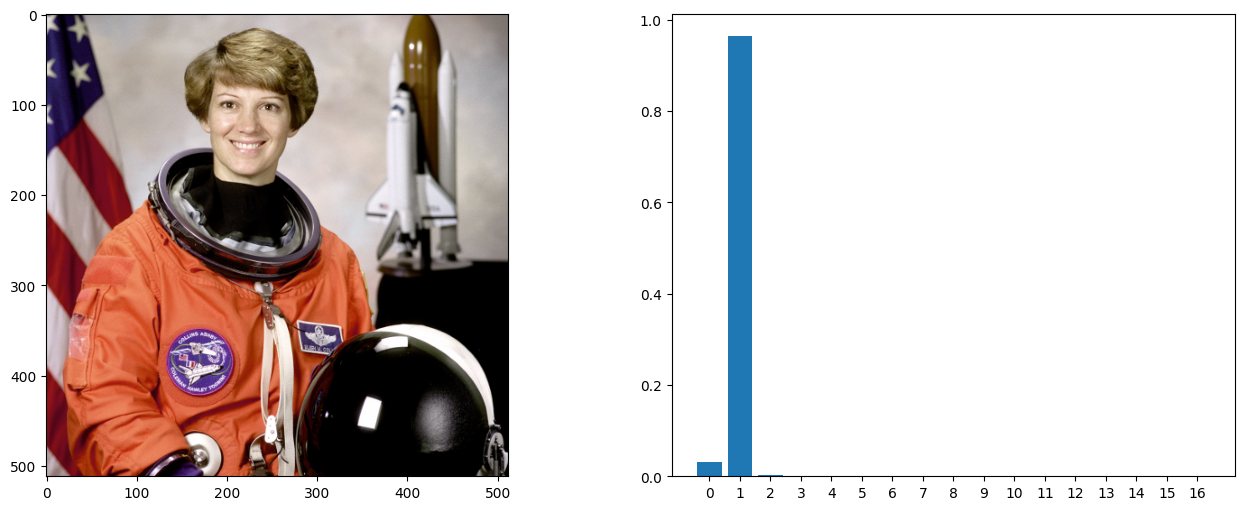

In [79]:
import matplotlib.pyplot as plt

def predict(index):
    print(text_descriptions[np.argmax(text_probs[index]).numpy()])
    f, ax = plt.subplots(1,2, figsize= (16, 6))
    ax[0].imshow(orig_images[index])
    ax[1].bar([str(i) for i in list(range(17))],text_probs[index])
    plt.show()

predict(0)

This is a camera


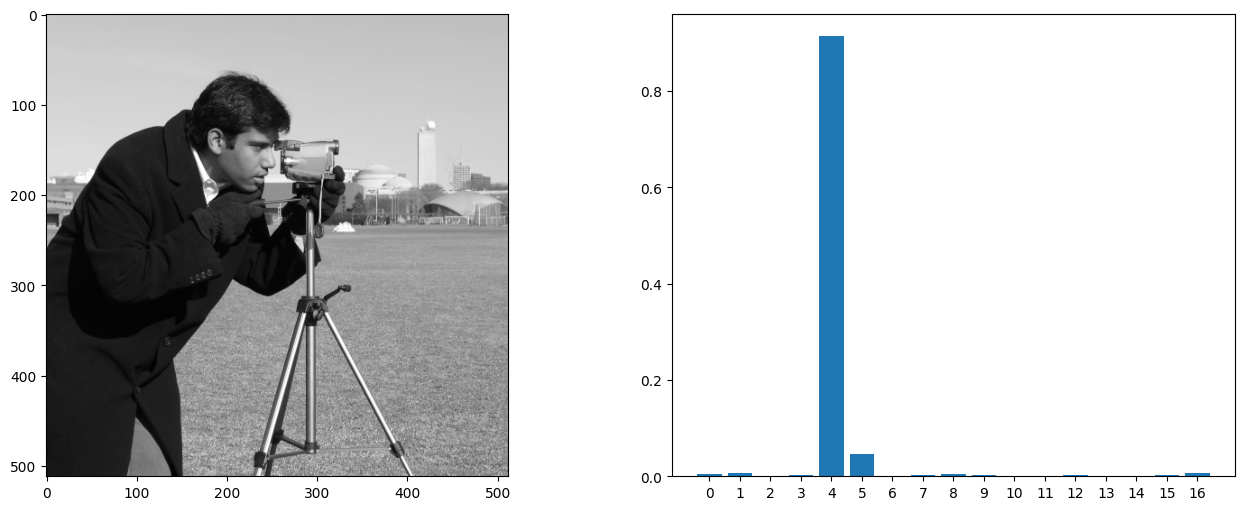

In [80]:
predict(1)

This is a cat


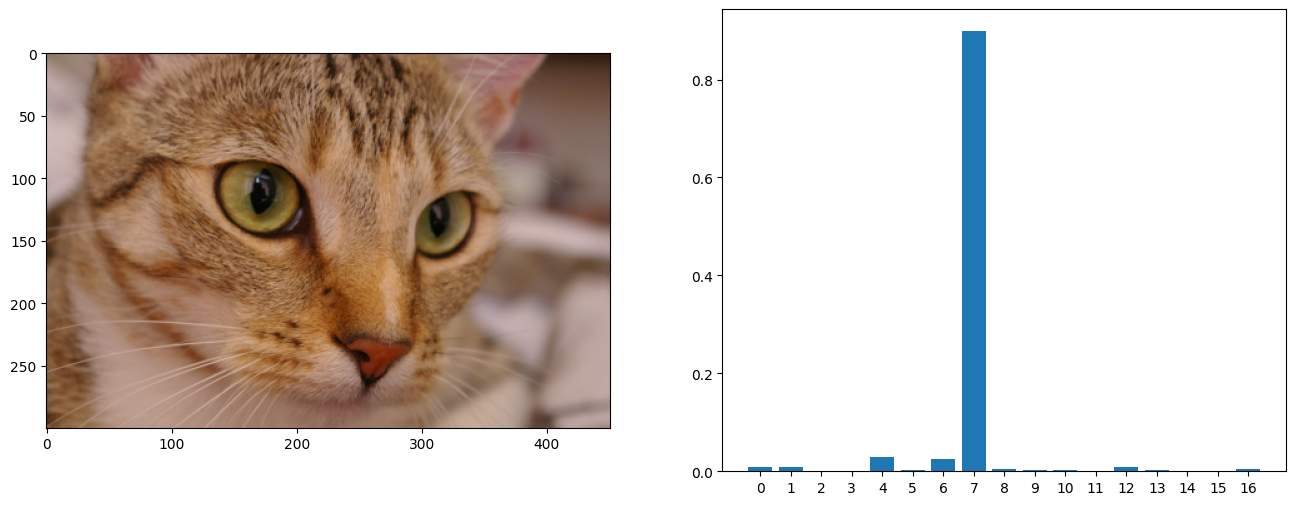

In [81]:
predict(2)

In [86]:
top_probs, top_labels = text_probs.topk(3, dim=-1)
top_labels = [[new_items[p] for p in pp] for pp in top_labels]
top_probs, top_labels

(tensor([[0.9640, 0.0315, 0.0017],
         [0.9136, 0.0453, 0.0067],
         [0.8986, 0.0285, 0.0243],
         [0.9948, 0.0014, 0.0011],
         [0.9955, 0.0018, 0.0016],
         [0.9020, 0.0758, 0.0100],
         [0.4784, 0.1807, 0.0940],
         [0.6776, 0.2237, 0.0346]]),
 [['astronaut', 'woman', 'spaceship'],
  ['camera', 'man', 'text'],
  ['cat', 'camera', 'dog'],
  ['coffee', 'spoon', 'table'],
  ['horse', 'dog', 'elephant'],
  ['bike', 'color', 'horse'],
  ['table', 'text', 'camera'],
  ['spaceship', 'astronaut', 'airplane']])

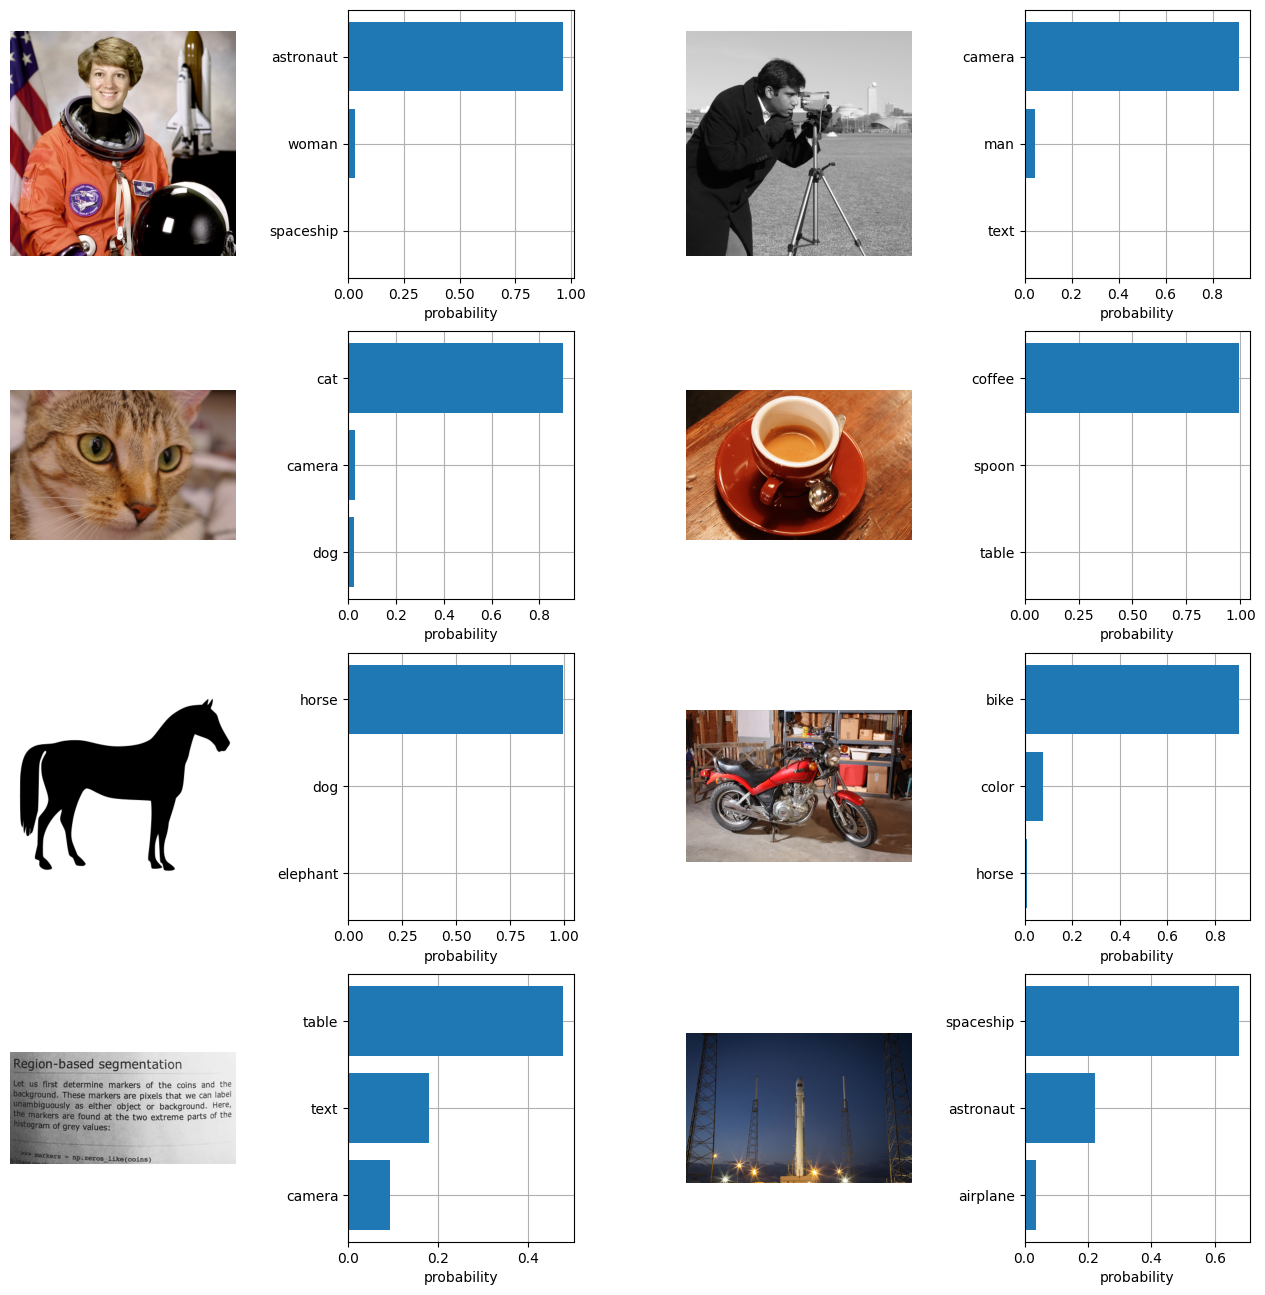

In [89]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(orig_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, top_labels[i])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()
     

In [ ]:
\\\